# Quiz 10 - Dimensionality Reduction

Take a supervised learning model you recently created and apply one dimensionality-reduction technique. How did it influence the performance?

In [28]:
# All of the following is taken from the Homework 9 XGBoost Model:

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

def create_dataframe(file: str, column_names: list[str]) -> pd.DataFrame:
    """
    Imports file into a Pandas dataframe, with specified column names
    """
    df = pd.read_csv(file, header = None)
    df.columns = column_names
    return df

file = "../Misc./adult.data"
column_names = ['age', 'work_class', 'pop_rep', 'education_lvl_cat', 'education_lvl_num', 'marital_status', 'occupation',
                'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hrs_worked_week', 'native_country', 'income']

adult_df = create_dataframe(file, column_names)

def label_encode_categoricals(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Label encodes categorical columns in dataframe
    """
    df_encoded = df.copy()
    label_encoder = LabelEncoder()
    for column in columns:
        df_encoded[column] = label_encoder.fit_transform(df[column])
    return df_encoded

adult_df_encoded = label_encode_categoricals(adult_df, ['work_class', 'marital_status', 'occupation', 'relationship',
                                                        'race', 'sex', 'native_country', 'income'])

def train_xgboost(df, target_col='income', n_estimators = 60, max_depth = 6, learning_rate = 0.3, random_state = 32):
    """
    Trains XGBoost model
    """
    X = df.drop(columns = ['income', 'pop_rep', 'education_lvl_cat', 'occupation', 'race', 'native_country'])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
    xgb = XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate = learning_rate, random_state = random_state)
    xgb.fit(X_train, y_train)
    return xgb, X_test, y_test

From here on out, this is new code.

Today, I'll be evaluating my XGBoost model's performance with ROC AUC.

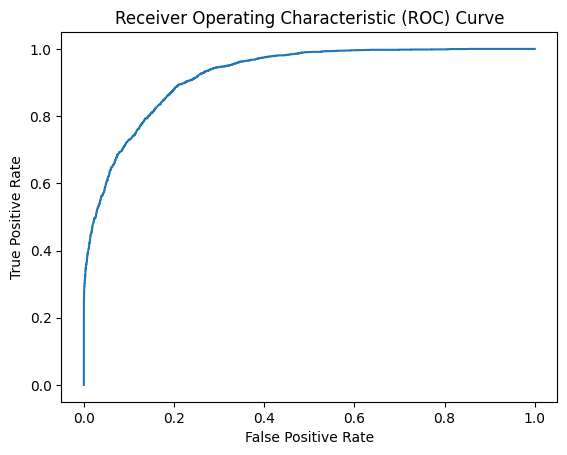

AUC score is: 0.9235519425278699


In [29]:
# Original model's AUC score and ROC curve:

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

def display_roc_auc(xgb, X_test, y_test):
    """
    Calculates AUC score for given XGBoost model and associated ROC curve
    """
    y_probs = xgb.predict_proba(X_test)[:, 1]
    roc_auc = roc_auc_score(y_test, y_probs)
    fpr, tpr, _ = roc_curve(y_test, y_probs)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.show()
    print("AUC score is:", roc_auc)

xgb, X_test, y_test = train_xgboost(adult_df_encoded)
display_roc_auc(xgb, X_test, y_test)

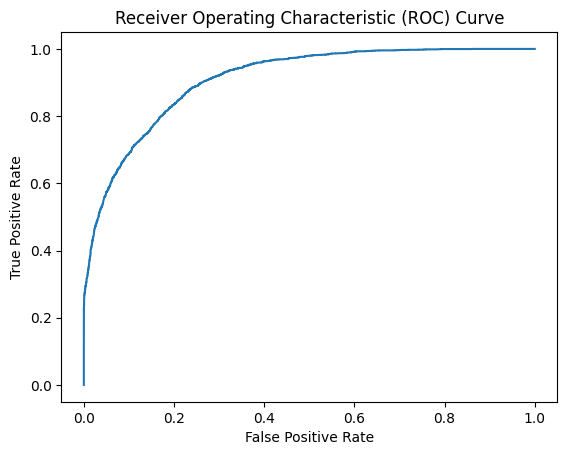

AUC score is: 0.9086578080926448


In [30]:
# New model's dimensionality reduction, then ROC AUC:

from sklearn.decomposition import PCA

def train_xgboost_pca(df, target_col = 'income', n_estimators = 60, max_depth = 6, learning_rate = 0.3, random_state = 32):
    """
    Trains XGBoost model with PCA without any preprocessing
    """
    X = df.drop(columns=['income', 'pop_rep', 'education_lvl_cat', 'occupation', 'race', 'native_country'])
    y = df[target_col]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = random_state)
    
    # PCA!
    pca = PCA()
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    
    # Business as usual:
    xgb = XGBClassifier(n_estimators = n_estimators, max_depth = max_depth, learning_rate = learning_rate, random_state = random_state)
    xgb.fit(X_train_pca, y_train)
    return xgb, X_test_pca, y_test

xgb_pca, X_test_pca, y_test_pca = train_xgboost_pca(adult_df_encoded)

display_roc_auc(xgb_pca, X_test_pca, y_test_pca)